# Temperature forecast for the general public (MAELSTROM-Yr dataset)

This dataset contains temperature weather forecast for the Nordic region, and are used to produce public weather forecasts on the weather app Yr (www.yr.no). The goal of the prediction task is to generate a deterministic temperature forecast together with an uncertainty range (10% to 90%) as shown here: https://www.yr.no/en/details/graph/5-18700/Norway/Oslo/Oslo/Oslo%20(Blindern).

The target field in the dataset is constructed using a high density network of citizen weather stations from [Netatmo](https://weathermap.netatmo.com/).

The current operational implementation uses a very simple regression model based on only a subset of the predictors available in the dataset. It is described in this article: https://journals.ametsoc.org/view/journals/bams/101/1/bams-d-18-0237.1.xml

## Prerequisites
To run the code in this notebook, you need the following packages:

`pip install climetlab climetlab_maelstrom_yr keras tensorflow numpy matplotlib`

In [ ]:
!pip install climetlab climetlab_maelstrom_yr

In [1]:
import tensorflow as tf
# all the layers used for U-net
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D,
                                     Conv2DTranspose, Input, MaxPool2D)
from tensorflow.keras.models import Model

2022-01-10 14:14:37.546151: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Loading the data
We can use climetlab to load the dataset into an xarray dataset. There will be several datasets available of different sizes: 300 MB (not available yet), 5GB, and 5TB (not available yet). The 5TB dataset contains the entire Nordic domain at 1x1 km resolution for all 60 hour leadtimes. The 5GB dataset contains only a subset of grid points (128x128) surrounding Oslo, Norway and only for leadtimes 6, 12, ..., 42 hours. All datasets contain the same input predictors and time period (4 years).

Currently, only "air_temperature" is available as the predictand parameter, however precipitation_amount will be added in the future.

The entire 5GB dataset will take a few minutes to load, since the data must be downloaded from europeanweather.cloud. Climetlab caches files locally, so files need not be when rerunning the code later. To only load a subset, add a dates argument to load_dataset, e.g. `dates=['2017-01-01', '2017-01-02']` or `dates=pandas.date_range(start="2017-01-01", end="2017-03-01", freq="1D")`.

In [2]:
import climetlab as cml
import pandas
import xarray as xr


In [ ]:
cmlds = cml.load_dataset(
        'maelstrom-yr',
        size='5GB',
        parameter='air_temperature',
    )
ds = cmlds.to_xarray()

This dataset contains the following dimensions and variables

In [5]:
#ds.to_netcdf("ap1-data.nc")
ds = xr.open_dataset("ap1-data.nc")
len(ds.time)

1457

In [6]:
ds

<xarray.Dataset>
Dimensions:          (char: 50, leadtime: 8, predictor: 49, record: 1457, x: 128, y: 128)
Coordinates:
  * x                (x) float32 -2.974e+05 -2.964e+05 ... -1.714e+05 -1.704e+05
  * y                (y) float32 -5.043e+05 -5.033e+05 ... -3.783e+05 -3.773e+05
  * leadtime         (leadtime) timedelta64[ns] 00:00:00 ... 1 days 18:00:00
    latitude         (y, x) float32 ...
    longitude        (y, x) float32 ...
Dimensions without coordinates: char, predictor, record
Data variables:
    time             (record) datetime64[ns] ...
    projection       int32 ...
    altitude         (y, x) float32 ...
    predictors       (record, y, x, predictor) float32 ...
    name_predictor   (predictor, char) |S1 ...
    units_predictor  (predictor, char) |S1 ...
    target           (record, y, x, leadtime) float32 ...

The dataset is mostly self explanatory. The `record` dimension represent different samples. The `predictor` variable contains all predictors stacked one after the other, including values for different leadtimes. The `target` variable contain target values.

### Plotting predictors and predictand (target)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

names = ds["name_predictor"].values
names = np.array([''.join([qq.decode('utf-8') for qq in names[p, :]]) for p in range(names.shape[0])])

num_leadtimes = len(ds["leadtime"])
unique_predictor_names = np.unique(names)
print("Available predictors:", unique_predictor_names)


Available predictors: ['air_temperature_2m' 'bias_recent' 'bias_yesterday' 'cloud_area_fraction'
 'precipitation_amount' 'x_wind_10m' 'y_wind_10m']


In [12]:
# ds["predictors"].values [time,lat,lon, predictors]

Text(0.5, 1.0, 'Target')

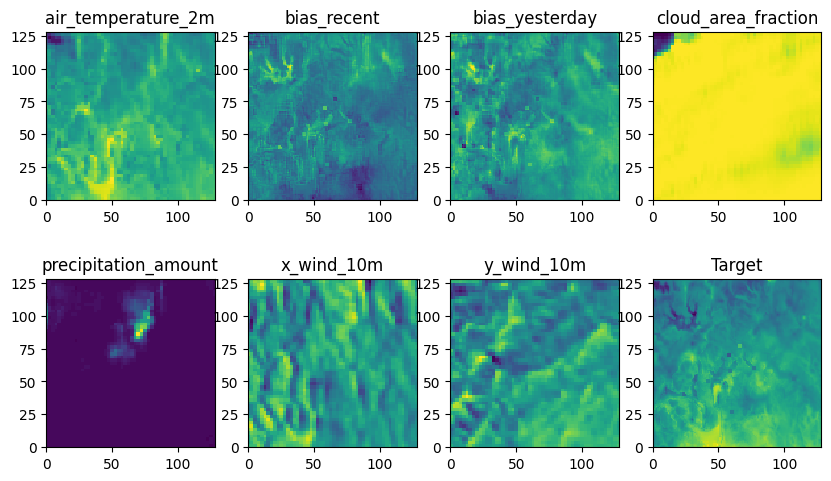

In [8]:
index_date = 0
target = ds["target"].values
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [10, 6]
for i, name in enumerate(unique_predictor_names):
    plt.subplot(2, 4, i + 1)
    index = np.where(names == name)[0][0]
    plt.pcolormesh(ds["predictors"][index_date, :, :, index], shading="auto", rasterized=True)
    plt.gca().set_aspect(1)
    plt.title(name)
plt.subplot(2, 4, 8)
plt.pcolormesh(target[index_date, :, :, 0], shading="auto", rasterized=True)
plt.gca().set_aspect(1)
plt.title("Target")

## Example ML solution
### Normalizing the predictors

First we normalize the predictors, by subtractng the mean and dividing by the standard deviation:

In [10]:
raw_forecast = np.copy(ds["predictors"][:, :, :, 0:num_leadtimes])
predictors = np.copy(ds["predictors"].values)
#num_predictors = predictors.shape[3]
# for p in range(num_predictors):
#     print("mean",np.nanmean(predictors[:, :, :, p]))
#     print("std",np.nanstd(predictors[:, :, :, p]))
#     predictors[:, :, :, p] -= np.nanmean(predictors[:, :, :, p])
#     predictors[:, :, :, p] /= np.nanstd(predictors[:, :, :, p])

In [11]:
np.max(predictors)

51.08203

In [12]:
batch_size = 4
Itrain = range(predictors.shape[0]//2)
Ieval = range(predictors.shape[0]//2, predictors.shape[0] - predictors.shape[0]% batch_size)

In [13]:
raw_forecast.shape

(1457, 128, 128, 8)

In [14]:
predictors = predictors.reshape((1457, 128, 128, 7, 7)) #[num_samples, lat,lon,time, channels]
predictors = predictors.transpose(0, 4, 1, 2, 3)

In [15]:
predictors.shape

(1457, 7, 128, 128, 7)

In [16]:
print(np.max(predictors[:,:,:,:,0]))
print(np.min(predictors[:,:,:,:,0]))

34.177643
-28.81398


In [17]:
target = target.reshape((1457, 128, 128, 8, 1))
target = target.transpose(0, 3, 1, 2, 4)

In [18]:
print("target max",np.max(target))
print("target min",np.min(target))

target max 36.201324
target min -33.753464


In [19]:
def max_min_norm(predictor):
    min_value = np.min(predictor)
    max_value = np.max(predictor)
    predictor = (predictor - min_value) / (max_value - min_value)
    return predictor

num_predictors = 7
for p in range(1, num_predictors):
    predictors[:, :, :, :, p] = max_min_norm(predictors[:, :, :, :, p])
    
predictors[:, :, :, :, 0] = (predictors[:, :, :, :, 0] - (-33.753464)) / (36.201324 - (-33.753464))

In [20]:
np.max(predictors)

1.0

In [21]:
target.shape

(1457, 8, 128, 128, 1)

In [22]:
target_scaled = (target - (-33.753464)) / (36.201324 - (-33.753464))
np.max(target_scaled)

1.0

In [23]:
np.min(target_scaled)

0.0

### Defining the loss function
We use the quantile loss function, by scoring each of the three output quantiles of the model:

In [24]:

global num_leadtimes
def quantile_loss_function(y_true, y_pred):
    err0 = y_true - y_pred[:, :, :, 0:num_leadtimes]
    err1 = y_true - y_pred[:, :, :, num_leadtimes:(2*num_leadtimes)]
    err2 = y_true - y_pred[:, :, :, (2*num_leadtimes):(3*num_leadtimes)]
    qtloss0 = (0.5 - tf.cast((err0 < 0), tf.float32)) * err0
    qtloss1 = (0.1 - tf.cast((err1 < 0), tf.float32)) * err1
    qtloss2 = (0.9 - tf.cast((err2 < 0), tf.float32)) * err2
    return K.mean(qtloss0 + qtloss1 + qtloss2)

In [25]:
#auxiliary functions used for parsing the hyerparameters from hparams_dict

def reduce_dict(dict_in: dict, dict_ref: dict):
    """
    Reduces input dictionary to keys from reference dictionary. If the input dictionary lacks some keys, these are 
    copied over from the reference dictionary, i.e. the reference dictionary provides the defaults
    :param dict_in: input dictionary
    :param dict_ref: reference dictionary
    :return: reduced form of input dictionary (with keys complemented from dict_ref if necessary)
    """
    method = reduce_dict.__name__

    # sanity checks
    assert isinstance(dict_in, dict), "%{0}: dict_in must be a dictionary, but is of type {1}"\
                                      .format(method, type(dict_in))
    assert isinstance(dict_ref, dict), "%{0}: dict_ref must be a dictionary, but is of type {1}"\
                                       .format(method, type(dict_ref)) 

    dict_merged = {**dict_ref, **dict_in}
    dict_reduced = {key: dict_merged[key] for key in dict_ref}

    return dict_reduced

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


In [26]:
#define your hparameters in a dictionary
hparams_dict = {
    "batch_size": 4,
    "lr": 0.001,
    "max_epochs": 5,
    "context_frames": 7,
    "sequence_length": 15,
    "ngf": 16,
    "gan": False
}

In [27]:
from tensorflow.keras.layers import (Input, Concatenate,Conv3D,LeakyReLU, Dense, Conv2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import sigmoid, linear
from tensorflow.keras.preprocessing.image import NumpyArrayIterator
tf.config.experimental_run_functions_eagerly(True)
import time
import keras
import tensorflow as tf
import keras.backend as K

class ConvLSTMVideoPredictionModel():

    def __init__(self, mode: str = "train", hparams_dict: dict = None,input_shape:list=None, target_shape:list=None): 
        """
         This is a class for building convLSTM GAN architecture by using updated hparameters
             mode                  : string, either "train" or "val" 
             hparams_dict          : dictionary, contains the hyperparameters names and default values
             input_shape           : tf.Tensor shape equal to the input shape
        """
        self.mode = mode
        self.hparams_dict = hparams_dict
        self.hparams = self.parse_hparams()
        self.batch_size = self.hparams.batch_size
        self.learning_rate = self.hparams.lr
        self.max_epochs = self.hparams.max_epochs
        self.sequence_length = self.hparams.sequence_length
        self.context_frames = self.hparams.context_frames
        self.loss_fun = self.hparams.loss_fun
        self.ngf = self.hparams.ngf
        self.gan = self.hparams.gan
        self.input_shape = input_shape
        self.target_shape = target_shape

    def parse_hparams(self): 
        self.hparams_dict = dotdict(self.hparams_dict)
        return self.hparams_dict

    @staticmethod
    def Unet_ConvLSTM_cell(inputs, channels_start:int, hidden: tf.Tensor=None):
        """
        Build up a Unet ConvLSTM cell for each time stamp i

        params:  inputs:             the input at timestamp i
        params: channels_start:      the numnber of filters for convoluational layers
        params: hidden:              the hidden state from the previous timestamp t-1
        params: cell_id:             the cell layer id
        return:
               outputs:              the predict frame at timestamp i
               hidden:               the hidden state at current timestamp i
        """

        #input_shape = x.get_shape().as_list()
        num_channels = inputs[-1]    
        assert len(inputs.shape) == 4
        

        """ encoder """
        s1, e1 = ConvLSTMVideoPredictionModel.encoder_block(inputs, channels_start, l_large=False)
        s2, e2 = ConvLSTMVideoPredictionModel.encoder_block(e1, channels_start*2, l_large=False)
        s3, e3 = ConvLSTMVideoPredictionModel.encoder_block(e2, channels_start*4, l_large=False)

        """ bridge encoder <-> decoder """
        convLSTM_input = ConvLSTMVideoPredictionModel.conv_block(e3, channels_start*8)
        convLSTM_input = tf.expand_dims(convLSTM_input, axis=1)
        assert len(convLSTM_input.shape) == 5

        # Apply convLSTM cell
        #The input for ConvLSTM2D must be 5-dim tensorflow 
        if hidden is not None:
            # if it is not the first timestamp, the hidden state will be 
            #concatenated with convLSTM inputs as inputs as next timestamp input
            convLSTM_input = Concatenate(axis=4)([convLSTM_input, hidden])
        else:
            pass

        b1, hidden1, hidden2 = tf.keras.layers.ConvLSTM2D(filters=10, kernel_size=2, return_state=True, 
                                                          padding='same',data_format='channels_last', activation='sigmoid')(convLSTM_input)
        assert len(b1.shape) == 4
        hidden = Concatenate(axis=3)([hidden1, hidden2])
        #Convert hidden layer from 4-dim to 5 dimension
        hidden = tf.expand_dims(hidden, axis=1)
        assert len(hidden.shape) == 5

        d1 = ConvLSTMVideoPredictionModel.decoder_block(b1, s3, channels_start*4)
        d2 = ConvLSTMVideoPredictionModel.decoder_block(d1, s2, channels_start*2)
        outputs = ConvLSTMVideoPredictionModel.decoder_block(d2, s1, 1)
      
        return outputs, hidden


    @staticmethod
    def conv_block(inputs: tf.Tensor = None, num_filters: int = None, kernel: tuple = (3,3), padding: str = "same",
                  activation: str = "relu", kernel_init: str = "he_normal", l_batch_normalization: bool = False): 

        """
        A convolutional layer with optional batch normalization
        :param inputs: the input data with dimensions nx, ny and nc
        :param num_filters: number of filters (output channel dimension)
        :param kernel: tuple indictating kernel size
        :param padding: technique for padding (e.g. "same" or "valid")
        :param activation: activation fuction for neurons (e.g. "relu")
        :param kernel_init: initialization technique (e.g. "he_normal" or "glorot_uniform")
        """
        x = Conv2D(num_filters, kernel, padding=padding, kernel_initializer=kernel_init)(inputs)
        if l_batch_normalization:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        return x
    
    @staticmethod
    def conv_block_n(inputs, num_filters, n=2, kernel=(3,3), padding="same", activation="relu", 
                         kernel_init="he_normal", l_batch_normalization=False):
        """
        Sequential application of two convolutional layers (using conv_block).
        """

        x = ConvLSTMVideoPredictionModel.conv_block(inputs, num_filters, kernel, padding, activation,
                       kernel_init, l_batch_normalization)
        for i in np.arange(n-1):
            x = ConvLSTMVideoPredictionModel.conv_block(x, num_filters, kernel, padding, activation,
                           kernel_init, l_batch_normalization)

        return x
    
    @staticmethod
    def encoder_block(inputs, num_filters, kernel_maxpool: tuple=(2,2), l_large: bool=False):
        """
        One complete encoder-block used in U-net
        """
        if l_large:
            x = ConvLSTMVideoPredictionModel.conv_block_n(inputs, num_filters, n=2)
        else:
            x = ConvLSTMVideoPredictionModel.conv_block(inputs, num_filters)

        p = MaxPool2D(kernel_maxpool)(x)

        return x, p
    
    @staticmethod
    def decoder_block(inputs, skip_features, num_filters, kernel: tuple=(3,3), strides_up: int=2, padding: str= "same",
                      activation: str="relu", kernel_init: str="he_normal", l_batch_normalization: bool=False):
        """
        One complete decoder block used in U-net (reverting the encoder)
        """

        x = Conv2DTranspose(num_filters, (strides_up, strides_up), strides=strides_up, padding="same")(inputs)
        x = Concatenate()([x, skip_features])
        x = ConvLSTMVideoPredictionModel.conv_block_n(x, num_filters, 2, kernel, padding, activation, kernel_init, l_batch_normalization)
        return x
    
    def generator(self):
        """
        Function to build up the generator architecture, here we take Unet_ConvLSTM as generator
        """

        x = Input(self.input_shape)
        network_template = tf.compat.v1.make_template("network",ConvLSTMVideoPredictionModel.Unet_ConvLSTM_cell)

        # create network
        x_hat = []
        #This is for training (optimization of convLSTM layer)
        hidden_g = None
        for i in range(self.sequence_length-1):
            if i < self.context_frames:
                x_1_g, hidden_g = network_template(inputs=x[:, i, :, :, :], channels_start=self.ngf, hidden=hidden_g)
            else:
                x_1_g, hidden_g = network_template(x_1_g, self.ngf, hidden_g)
            x_hat.append(x_1_g)

        # pack them all together
        x_hat = tf.stack(x_hat)
        self.x_hat = tf.transpose(x_hat, [1, 0, 2, 3, 4])
        G = Model(x, self.x_hat)
        return G

    def discriminator(self):
        """
        Discriminator: this discriminaotr so far perfoms best on the precipitation dataset
        """
        
        x = Input(self.target_shape)
        conv1 = Conv3D(filters=4, kernel_size=2, strides=(1, 1, 1), padding='same')(x)
        conv1 = Activation("relu")(conv1)
        conv2 = tf.reshape(conv1, [-1,1])
        fc2 = LeakyReLU(0.2)(conv2)
        out_logit = Dense(1)(fc2)
        out = tf.nn.sigmoid(out_logit) 
        D = Model(x, [out,out_logit])
        return D


    def define_optimizers(self):

        self.d_optim = tf.keras.optimizers.Adam(self.learning_rate)
        self.g_optim = tf.keras.optimizers.Adam(self.learning_rate)
        
    def get_gen_loss(self):
        """
        Define generator loss

        Return:  the loss of generator given inputs
        """
        real_labels = tf.ones_like(self.D_fake)
        self.G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_fake_logits, labels=real_labels))            
        
        return self.G_loss
    

    def get_disc_loss(self):
        """
        Return the loss of discriminator given inputs
        """
        real_labels = tf.ones_like(self.D_real)
        gen_labels = tf.zeros_like(self.D_fake)
        self.D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_real_logits,
                                                                                  labels=real_labels))
        self.D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_fake_logits,
                                                                                  labels=gen_labels))
        self.D_loss = self.D_loss_real + self.D_loss_fake

        return self.D_loss
 
    def get_recon_loss(self, target, gen_images):
        recon_loss = tf.reduce_mean(tf.square(target - gen_images))
        return recon_loss

    @tf.function     
    def train_step(self, inputs, target, i):
        """
        Training models
        """
        self.G = self.generator()
        self.D = self.discriminator()
        self.define_optimizers()
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:

            gen_images = self.G(inputs)
            self.D_real, self.D_real_logits = self.D(target)
            self.D_fake, self.D_fake_logits = self.D(gen_images[:,self.context_frames-1:,:,:,0]) 

            g_loss = self.get_gen_loss()
            d_loss = self.get_disc_loss()
            recon_loss = self.get_recon_loss(target[:, :, :, :, 0], gen_images[:,self.context_frames-1:,:,:,0])
            d_gradients = d_tape.gradient(d_loss, self.D.trainable_variables)

            if not self.gan:
                if i == 0:
                    print("You are only training generator")
                # if the discriminator is not used for training, only train generator part
                g_gradients = g_tape.gradient(recon_loss, self.G.trainable_variables)
                self.g_optim.apply_gradients(zip(g_gradients, self.G.trainable_variables))
            else:
                if i == 0:
                    print("You are training both generator and discriminator")
                g_gradients = g_tape.gradient(g_loss + recon_loss, self.G.trainable_variables)
                self.d_optim.apply_gradients(zip(d_gradients, self.D.trainable_variables))
                self.g_optim.apply_gradients(zip(g_gradients, self.G.trainable_variables))

        return g_loss, d_loss, recon_loss


    def calculate_samples(self,predictors,train_ratio=0.5):
        """
        calculate the number of training and validatioin samples 
        """
        self.Itrain = range(int(predictors.shape[0]*train_ratio))
        self.Ieval = range(int(predictors.shape[0]*train_ratio), predictors.shape[0])
        self.train_samples = int(predictors.shape[0]*train_ratio)
        self.val_samples = predictors.shape[0] - int(predictors.shape[0]*train_ratio)
        print("Total samples: {}, trainng samples: {}".format(self.train_samples + self.val_samples,self.train_samples))


    def make_data_generator(self, predictors, target):
        self.calculate_samples(predictors)
        train_predictors, train_target = predictors[Itrain, ...], target[Itrain, ...]
        val_predictors, val_target = predictors[Ieval, ...], target[Ieval, ...]
        train_dataset = tf.data.Dataset.from_tensor_slices((train_predictors,train_target))
        val_dataset = tf.data.Dataset.from_tensor_slices((val_predictors,val_target))
        train_dataset = train_dataset.shuffle(100).repeat(self.max_epochs).batch(self.batch_size)
        val_dataset = val_dataset.batch(self.batch_size)
        self.train_iterator = iter(train_dataset)
        self.val_iterator = iter(val_dataset) 

    def train(self,log_freq=5):

        iterations_epoch = self.train_samples // self.batch_size
        iteration = self.max_epochs * iterations_epoch

        for step in range(iteration):
            (x,y) = next(self.train_iterator)
            
            train_start_time = time.time()
            g_loss, d_loss, recon_loss = self.train_step(x, y, step)
            train_step_time = time.time() - train_start_time

            if step % log_freq == 0:
                template = '[{}/{}] D_loss={:.5f} G_loss={:.5f}, g_recon_loss={:.5f} training time per step: {:.5f}/s'
                print(template.format(step, iteration, d_loss,g_loss,recon_loss, train_step_time))


    def prediction(self):
        iterations = self.val_samples // self.batch_size
        (x_val,y_val) = next(self.val_iterator)
        is_first = True
        for i in range(iterations):
            output = modelCase.G(x_val)
            if is_first:
                outputs = output
                is_first = False
            else:
                outputs = np.concatenate((outputs,output), axis=0)
        print("Inference is done")
        return outputs

modelCase = ConvLSTMVideoPredictionModel(mode="train", hparams_dict=hparams_dict,
                                         input_shape=[7,128,128,7],target_shape=[8,128,128,1])
modelCase.make_data_generator(predictors, target_scaled)
modelCase.train()


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
Total samples: 1457, trainng samples: 728


2022-01-10 14:21:41.998485: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-10 14:21:42.054593: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-10 14:21:42.054628: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jwc02n073.juwels): /proc/driver/nvidia/version does not exist
2022-01-10 14:21:42.151366: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-10 14:21:42.172953: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune usi

You are only training generator
[0/910] D_loss=1.38660 G_loss=0.69317, g_recon_loss=0.23689 training time per step: 6.59680/s
[5/910] D_loss=1.45040 G_loss=0.69339, g_recon_loss=0.22194 training time per step: 5.34084/s
[10/910] D_loss=1.37902 G_loss=0.68877, g_recon_loss=0.42098 training time per step: 5.11439/s
[15/910] D_loss=1.29342 G_loss=0.69265, g_recon_loss=0.31482 training time per step: 5.19608/s
[20/910] D_loss=1.45626 G_loss=0.69762, g_recon_loss=0.25326 training time per step: 5.20565/s
[25/910] D_loss=1.32738 G_loss=0.69285, g_recon_loss=0.32942 training time per step: 5.21739/s
[30/910] D_loss=1.39794 G_loss=0.69324, g_recon_loss=0.29307 training time per step: 5.28609/s
[35/910] D_loss=1.59532 G_loss=0.69373, g_recon_loss=0.49998 training time per step: 5.28047/s
[40/910] D_loss=1.23277 G_loss=0.68976, g_recon_loss=0.44487 training time per step: 5.34972/s
[45/910] D_loss=1.37728 G_loss=0.69239, g_recon_loss=0.36089 training time per step: 5.18275/s
[50/910] D_loss=1.34

In [28]:
output = modelCase.prediction()

Inference is done


In [29]:
import tensorflow.keras.utils as ku
ku.plot_model(model, show_shapes=True)

NameError: name 'model' is not defined

### Setting up the model
The model takes a gridded predictor set as input and outputs gridded fields for each leadtime and for three quantiles. The tempearture forecast on yr.no has both a deterministic best guess and a 10-90% confidence interval. We want the model to predict all three parameters simultaneously.

In [ ]:
num_quantiles = 3
num_outputs = num_quantiles * num_leadtimes
# model = keras.Sequential()
# model.add(keras.layers.InputLayer(predictors.shape[1:]))
# model.add(keras.layers.Dense(num_outputs))
# model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2), loss = quantile_loss_function)
# model.summary()
print(num_outputs)

## Model evaluation and visualization

### Evaluating the model
First, lets compare the mean absolute error of the raw forecast and the ML-forecast of the median

In [ ]:
import numpy as np
#rescale the target value
output = output * (36.201324 - (-33.753464))  - 33.753464

In [ ]:
print("ML MAE:", np.nanmean(np.abs(output[:, 0:num_leadtimes, :,:,:] - target[Ieval,...])), "°C")

Next, we can plot the MAE as a function of leadtime:

In [ ]:
x = ds["leadtime"].astype(float) / 3600 / 1e9
plt.plot(x, [np.nanmean(np.abs(output[:, :, :, i] - target[Ieval, :, :, i])) for i in range(num_leadtimes)], 'ro-', lw=2, label="Model")
plt.plot(x, [np.nanmean(np.abs(raw_forecast[Ieval, :, :, i] - target[Ieval, :, :, i])) for i in range(num_leadtimes)], 'yo-', lw=2, label="Raw")
plt.legend()
plt.xlabel("Lead time (hours)")
plt.ylabel("Mean absolute error (°C)")


### Visualizing the results as timeseries
We can visualize the output as a timeseries. We will pick an example point (Oslo).

In [ ]:
Y = 55
X = 55
plt.plot(x, output[0, Y, X, 0:num_leadtimes], 'r-', lw=2, label="Median")
plt.plot(x, raw_forecast[Ieval[0], Y, X, 0:num_leadtimes], 'y-', lw=2, label="Raw")
lower = output[0, Y, X,num_leadtimes:2*num_leadtimes]
upper = output[0, Y, X, 2*num_leadtimes:3*num_leadtimes]
plt.plot(x, lower, 'r--', lw=2, label="10%")
plt.plot(x, upper, 'r--', lw=2, label="90%")
xx = np.concatenate((x, x[::-1]))
plt.fill(np.concatenate((x, x[::-1])), np.concatenate((lower, upper[::-1])), color='r', alpha=0.2, linewidth=0)
plt.plot(x, target[Ieval[0], Y, X, :], 'bo-', lw=2, label="Target")
plt.legend()
plt.xlabel("Lead time (hours)")
plt.ylabel("Air temperature (°C)")

### Visualizing the results on a map

Text(0.5, 1.0, 'Target (median)')

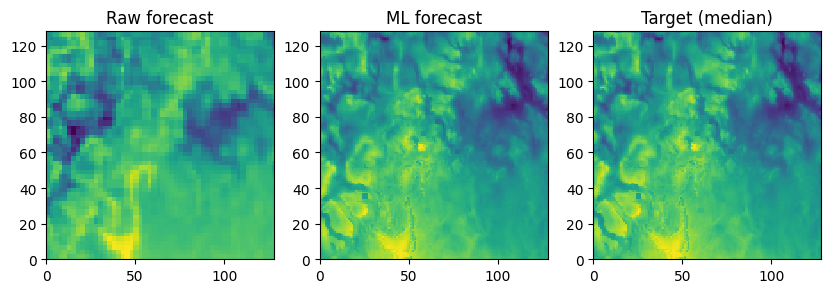

In [15]:
plt.subplot(1, 3, 1)
plt.pcolormesh(raw_forecast[Ieval[0], :, :, 0], rasterized=True)
plt.gca().set_aspect(1)
plt.title("Raw forecast")

plt.subplot(1, 3, 2)
plt.pcolormesh(output[0, :, :, 0], rasterized=True)
plt.gca().set_aspect(1)
plt.title("ML forecast")

plt.subplot(1, 3, 3)
plt.pcolormesh(target[Ieval[0], :, :, 0], rasterized=True)
plt.gca().set_aspect(1)
plt.title("Target (median)")